In [1]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Ler/Importar Dataset
df = pd.read_csv('pns-2019_saude_mulher_tratado.csv')

In [3]:
def recod_escolaridade(x):
    if x in ["Sem instrução", "Creche", "Pré-escola"]:
        return "Baixa"
    elif x in [
        "Regular do ensino fundamental",
        "EJA do ensino fundamental",
        "Regular do ensino médio",
        "EJA do ensino médio"
    ]:
        return "Media"
    elif x in [
        "Superior - graduação",
        "Especialização (mín. 360h)",
        "Mestrado",
        "Doutorado"
    ]:
        return "Alta"
    else:
        return np.nan

df["Escolaridade_3cat"] = df["Escolaridade"].apply(recod_escolaridade)

In [4]:
def recod_estado_civil(x):
    if x == "Casada":
        return "Casada"
    elif x == "Solteira":
        return "Solteira"
    elif x in ["Divorciada", "Viúva"]:
        return "Outros"
    else:
        return np.nan

df["Estado_Civil_3cat"] = df["Estado_Civil"].apply(recod_estado_civil)

In [5]:
df["Classificacao_IMC"] = df["Classificacao_IMC"].replace(
    {"Não informado": np.nan}
)

In [6]:
viol_vars = [
    "Forcou_RelSexual_Vida",
    "Consequencia_psicologicas"
]

df[viol_vars] = df[viol_vars].fillna(0)

In [7]:
variaveis_finais = [
    "Depressao",
    "Idade",
    "Escolaridade_3cat",
    "Estado_Civil_3cat",
    "Classificacao_IMC",
    "Forcou_RelSexual_Vida",
    "Consequencia_psicologicas"
]

df_modelo_final = df[variaveis_finais].dropna(subset=["Depressao"])

df_modelo_final = pd.get_dummies(
    df_modelo_final,
    columns=[
        "Escolaridade_3cat",
        "Estado_Civil_3cat",
        "Classificacao_IMC"
    ],
    drop_first=True
)

In [8]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import pandas as pd
import numpy as np

X = df_modelo_final.drop(columns="Depressao")
y = df_modelo_final["Depressao"].astype(int)


In [9]:
cat_features = X.select_dtypes(include=["object"]).columns.tolist()
cat_features


[]

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)


In [11]:
cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function="Logloss",
    eval_metric="AUC",
    auto_class_weights="Balanced",   
    random_seed=42,
    verbose=100
)


cat_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_test, y_test),
    use_best_model=True
)


0:	test: 0.8369126	best: 0.8369126 (0)	total: 55.4ms	remaining: 27.6s
100:	test: 0.8566392	best: 0.8566829 (89)	total: 902ms	remaining: 3.56s
200:	test: 0.8568926	best: 0.8569501 (172)	total: 1.73s	remaining: 2.57s
300:	test: 0.8560295	best: 0.8569501 (172)	total: 2.52s	remaining: 1.67s
400:	test: 0.8548636	best: 0.8569501 (172)	total: 3.34s	remaining: 826ms
499:	test: 0.8533510	best: 0.8569501 (172)	total: 4.23s	remaining: 0us

bestTest = 0.8569500899
bestIteration = 172

Shrink model to first 173 iterations.


In [18]:
y_pred = cat_model.predict(X_test)
y_prob_cat = cat_model.predict_proba(X_test)[:, 1]


In [19]:
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob_cat))



              precision    recall  f1-score   support

           0       0.99      0.74      0.84     41569
           1       0.13      0.84      0.22      1913

    accuracy                           0.74     43482
   macro avg       0.56      0.79      0.53     43482
weighted avg       0.95      0.74      0.82     43482

ROC AUC: 0.8569500898606072


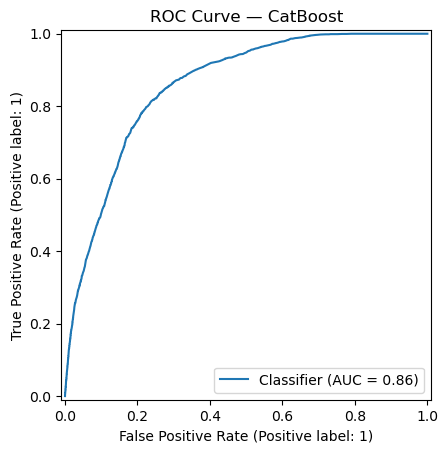

In [20]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

RocCurveDisplay.from_predictions(y_test, y_prob_cat)
plt.title("ROC Curve — CatBoost")
plt.show()


In [21]:
feat_imp = pd.DataFrame({
    "feature": X.columns,
    "importance": cat_model.get_feature_importance()
}).sort_values("importance", ascending=False)

feat_imp.head(10)


,feature,importance
0,Idade,58.528042
7,Classificacao_IMC_Obesidade,18.095271
2,Consequencia_psicologicas,9.849663
3,Escolaridade_3cat_Baixa,3.911760
4,Escolaridade_3cat_Media,2.806706
1,Forcou_RelSexual_Vida,2.734752
6,Estado_Civil_3cat_Solteira,1.770117
5,Estado_Civil_3cat_Outros,1.605189
9,Classificacao_IMC_Sobrepeso,0.515525
8,Classificacao_IMC_Peso normal,0.182975


In [22]:
# SALVAR y_test (referência única)
y_test.to_csv("y_test.csv", index=False)


In [23]:
import numpy as np

np.save("y_prob_cat.npy", y_prob_cat)
